# Telco Customer Churn — Portfolio EDA (Matplotlib + Pandas)

This notebook is designed to be **portfolio-ready**: it follows a **question → evidence → insight** workflow instead of dumping dozens of plots.

## Goals
- Understand the **baseline churn rate**
- Identify **high-signal drivers** of churn (contract, tenure, pricing, internet type, support add-ons)
- Produce **actionable segments** (who is at risk?) with simple, explainable evidence

> Dataset: Kaggle “Telco Customer Churn” (BlastChar). See the repo README for download/setup instructions.


---
## 0) Setup


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot defaults (formatting only; no custom colors)
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
})


---
## 1) Load data

Place the CSV in a `data/` folder (recommended), or set `DATA_PATH` to your file path.


In [2]:
# Try common locations automatically
CANDIDATE_PATHS = [
    Path("data/WA_Fn-UseC_-Telco-Customer-Churn.csv"),
    Path("WA_Fn-UseC_-Telco-Customer-Churn.csv"),
    Path("data/Telco-Customer-Churn.csv"),
    Path("Telco-Customer-Churn.csv"),
    Path("Telco-Customer-Churn.csv.csv"),
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find the dataset CSV. Put it in ./data/ or update CANDIDATE_PATHS."
    )

df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
df.head()


Loaded: data\WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---
## 2) Quick audit: dtypes + missingness (before cleaning)


In [3]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_only = missing_pct[missing_pct > 0]
print("No missing" if missing_only.empty else "")
missing_only.head(20)

No missing


Series([], dtype: float64)

---
## 3) Cleaning (minimal and explainable)

### Why `TotalCharges` becomes missing after conversion
In the raw CSV, `TotalCharges` may contain **blank strings** (`" "`) for **brand-new customers** (`tenure == 0`).  
When we convert to numeric, those blanks become `NaN` (missing).

### Cleaning steps
- Convert `TotalCharges` to numeric (`errors="coerce"`)
- If `tenure == 0` and `TotalCharges` is missing, set it to **0** (no billing yet)
- Map target `Churn` from Yes/No to **1/0**


In [5]:
df_clean = df.copy()

# Fix TotalCharges
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

# Impute only where it makes business sense (new customers)
mask_new = df_clean["TotalCharges"].isna() & (df_clean["tenure"] == 0)
df_clean.loc[mask_new, "TotalCharges"] = 0

# If anything remains missing, drop those rows (should be rare)
df_clean = df_clean.dropna(subset=["TotalCharges"]).reset_index(drop=True)

# Target encoding (keep original values if you want later; here we overwrite for convenience)
df_clean["Churn"] = df_clean["Churn"].map({"Yes": 1, "No": 0})

# Optional: readable SeniorCitizen label for plots
df_clean["SeniorCitizen_label"] = df_clean["SeniorCitizen"].map({0: "No", 1: "Yes"})

print("After cleaning:", df_clean.shape)
df_clean[["tenure","MonthlyCharges","TotalCharges","Churn"]].describe().T

After cleaning: (7043, 22)


,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00


---
## 4) Baseline: churn rate


,count,pct
Churn,,
No churn,5174,73.46
Churn,1869,26.54


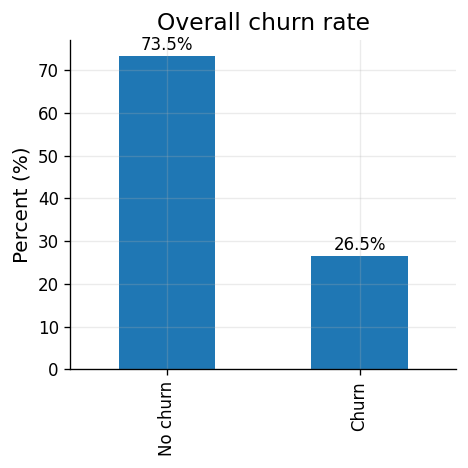

In [6]:
churn_counts = df_clean["Churn"].value_counts().sort_index()
churn_pct = df_clean["Churn"].value_counts(normalize=True).sort_index() * 100

display(pd.DataFrame({"count": churn_counts, "pct": churn_pct.round(2)}).rename(index={0:"No churn", 1:"Churn"}))

# Plot
plt.figure(figsize=(4,4))
ax = churn_pct.rename(index={0:"No churn", 1:"Churn"}).plot(kind="bar")
ax.set_title("Overall churn rate")
ax.set_ylabel("Percent (%)")
ax.set_xlabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for i, v in enumerate(churn_pct.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


---
## 5) Feature groups (for EDA)

We avoid “plot everything”. We focus on features that are:
- plausible levers (contract, pricing, support)
- high-signal (large churn separation)


In [7]:
# Numeric features we care about
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]

# High-signal categorical candidates (commonly informative in this dataset)
cat_features = [
    "Contract",
    "InternetService",
    "PaymentMethod",
    "PaperlessBilling",
    "TechSupport",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "SeniorCitizen_label",
]

# Confirm columns exist (in case your CSV differs)
cat_features = [c for c in cat_features if c in df_clean.columns]
num_features = [c for c in num_features if c in df_clean.columns]

print("Numeric:", num_features)
print("Categorical:", cat_features)

Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['Contract', 'InternetService', 'PaymentMethod', 'PaperlessBilling', 'TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'SeniorCitizen_label']


---
## 6) Numeric vs churn

We use **boxplots** (quick separation check) and a **tenure-binned churn curve** (very interpretable).


<Figure size 600x480 with 0 Axes>

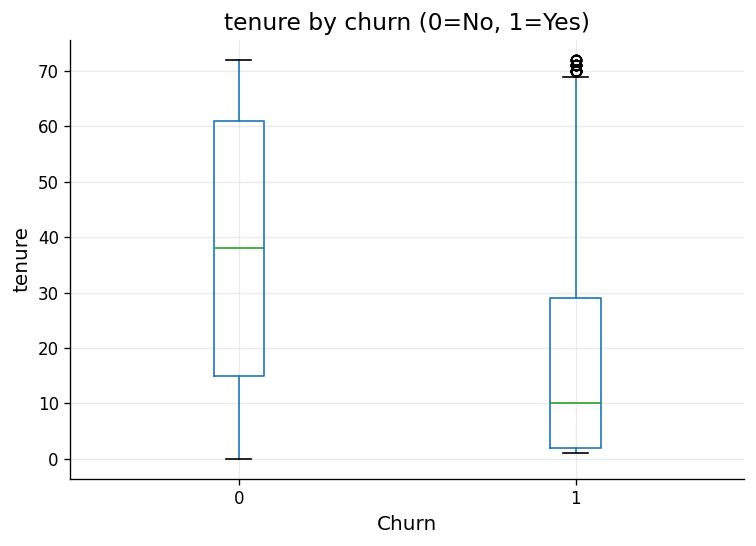

<Figure size 600x480 with 0 Axes>

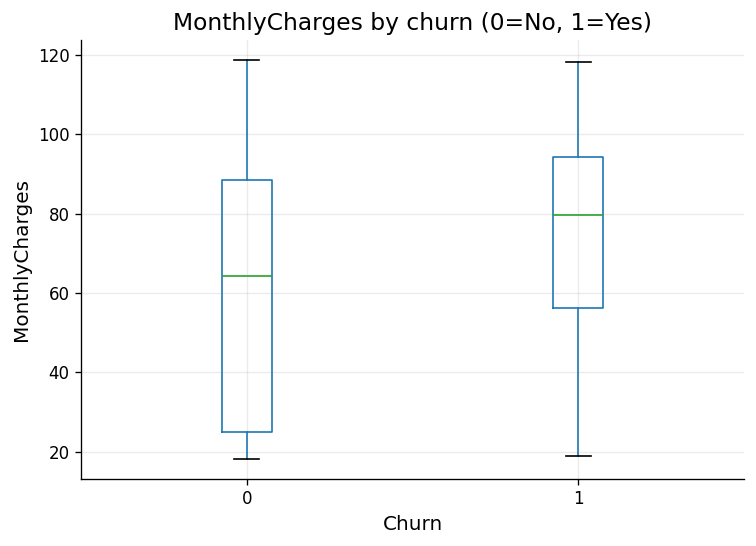

<Figure size 600x480 with 0 Axes>

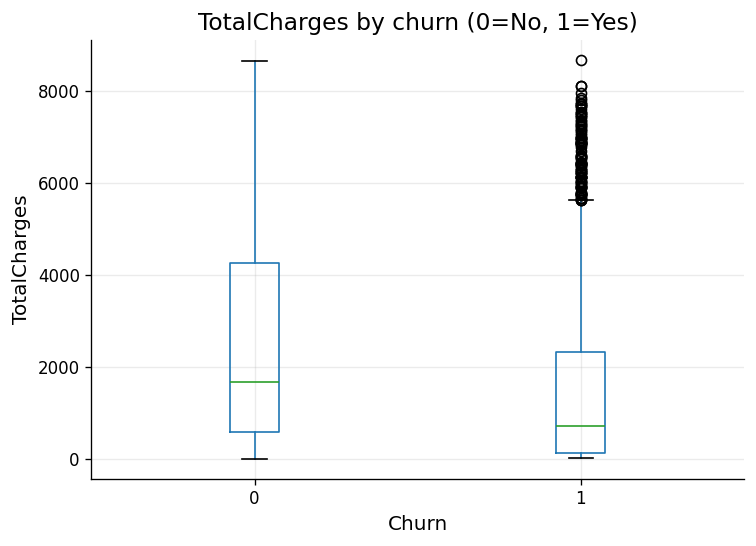

In [8]:
# Boxplots: numeric feature by churn
for col in num_features:
    plt.figure(figsize=(5,4))
    ax = df_clean.boxplot(column=col, by="Churn")
    plt.title(f"{col} by churn (0=No, 1=Yes)")
    plt.suptitle("")
    plt.xlabel("Churn")
    plt.ylabel(col)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25436\2961903436.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df_clean.groupby("tenure_bin")["Churn"].mean().mul(100)


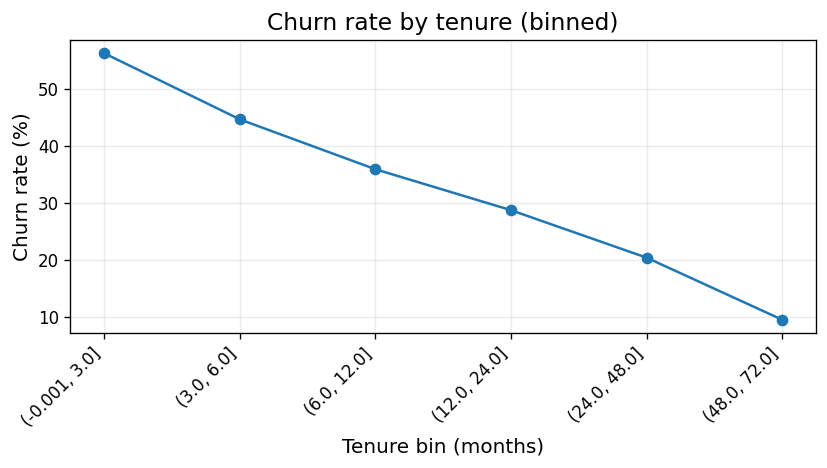

tenure_bin
(-0.001, 3.0]    56.21
(3.0, 6.0]       44.63
(6.0, 12.0]      35.89
(12.0, 24.0]     28.71
(24.0, 48.0]     20.39
(48.0, 72.0]      9.51
Name: Churn, dtype: float64

In [9]:
# Tenure-binned churn rate (highly interpretable)
bins = [0, 3, 6, 12, 24, 48, 72]
df_clean["tenure_bin"] = pd.cut(df_clean["tenure"], bins=bins, include_lowest=True)

tenure_churn = df_clean.groupby("tenure_bin")["Churn"].mean().mul(100)

plt.figure(figsize=(7,4))
ax = tenure_churn.plot(kind="line", marker="o")
ax.set_title("Churn rate by tenure (binned)")
ax.set_ylabel("Churn rate (%)")
ax.set_xlabel("Tenure bin (months)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

tenure_churn.round(2)


---
## 7) Categorical vs churn (churn rate by category)

This is the **most important** view for contract / internet / payment variables.


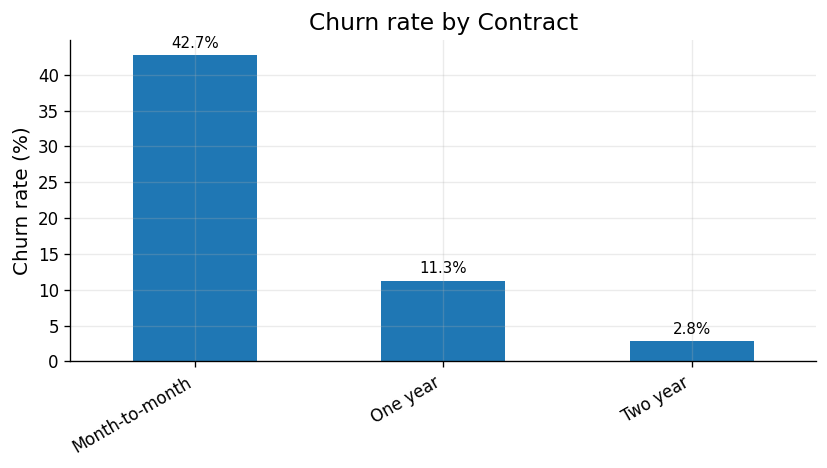

,count,churn_rate_pct
Contract,,
Month-to-month,3875,42.71
One year,1473,11.27
Two year,1695,2.83


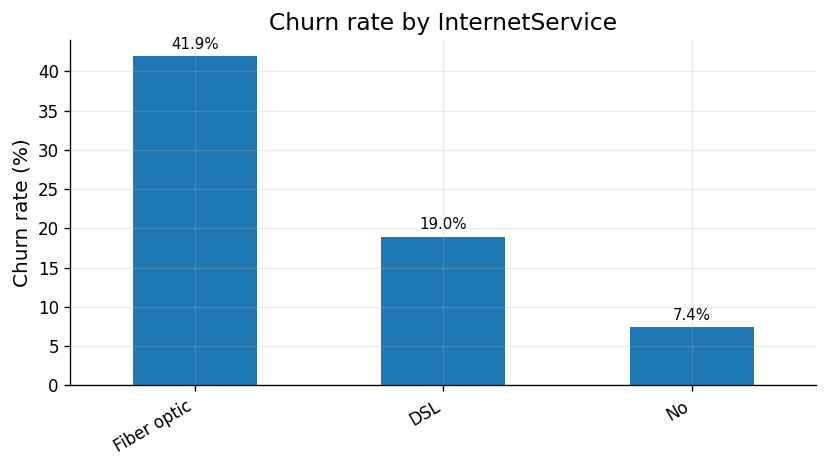

,count,churn_rate_pct
InternetService,,
Fiber optic,3096,41.89
DSL,2421,18.96
No,1526,7.40


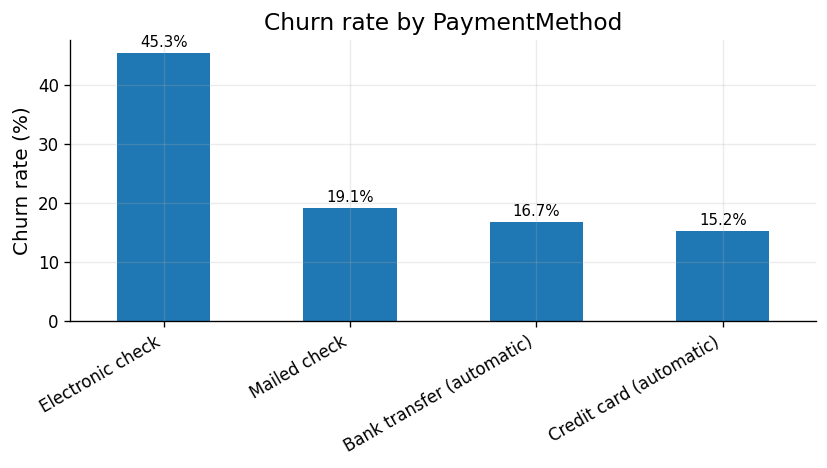

,count,churn_rate_pct
PaymentMethod,,
Electronic check,2365,45.29
Mailed check,1612,19.11
Bank transfer (automatic),1544,16.71
Credit card (automatic),1522,15.24


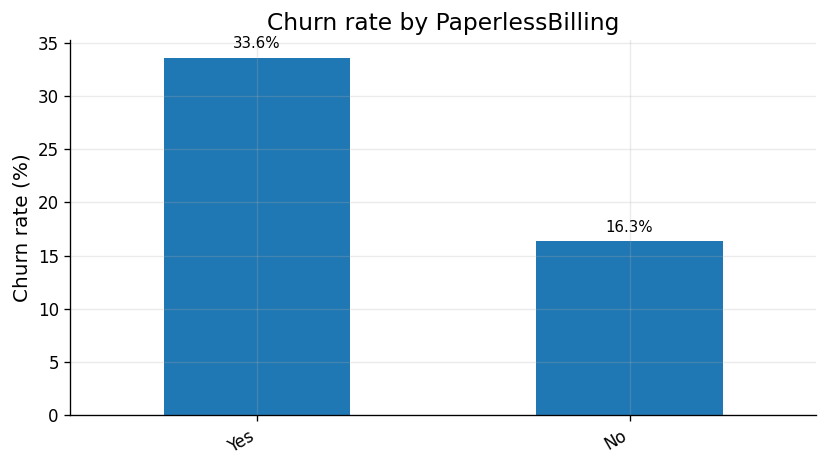

,count,churn_rate_pct
PaperlessBilling,,
Yes,4171,33.57
No,2872,16.33


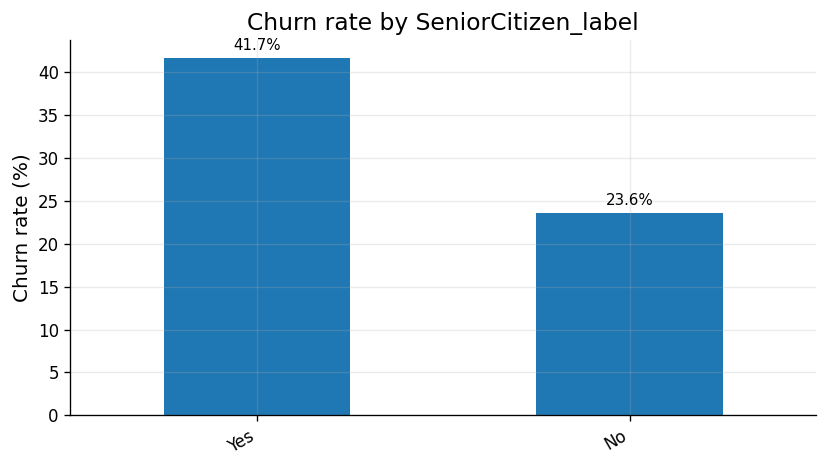

,count,churn_rate_pct
SeniorCitizen_label,,
Yes,1142,41.68
No,5901,23.61


In [10]:
def churn_rate_bar(df_in: pd.DataFrame, col: str, top_n: int | None = None):
    rate = df_in.groupby(col)["Churn"].mean().sort_values(ascending=False).mul(100)
    counts = df_in[col].value_counts()

    if top_n is not None and len(rate) > top_n:
        rate = rate.head(top_n)

    plt.figure(figsize=(7,4))
    ax = rate.plot(kind="bar")
    ax.set_title(f"Churn rate by {col}")
    ax.set_ylabel("Churn rate (%)")
    ax.set_xlabel("")
    plt.xticks(rotation=30, ha="right")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # annotate
    for i, v in enumerate(rate.values):
        ax.text(i, v + 0.6, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    # return a tidy table
    out = pd.DataFrame({
        "count": counts.loc[rate.index].values,
        "churn_rate_pct": rate.round(2).values,
    }, index=rate.index)
    return out

key_cats = ["Contract", "InternetService", "PaymentMethod", "PaperlessBilling", "SeniorCitizen_label"]
for c in key_cats:
    if c in df_clean.columns:
        display(churn_rate_bar(df_clean, c))


---
## 8) Add-on services (done correctly)

Add-on columns like `TechSupport`, `OnlineSecurity`, etc. include a **"No internet service"** category.  
To isolate the impact of the add-on itself, we analyze **only customers who have internet**.


Internet customers: 5517
Addon cols: ['TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']


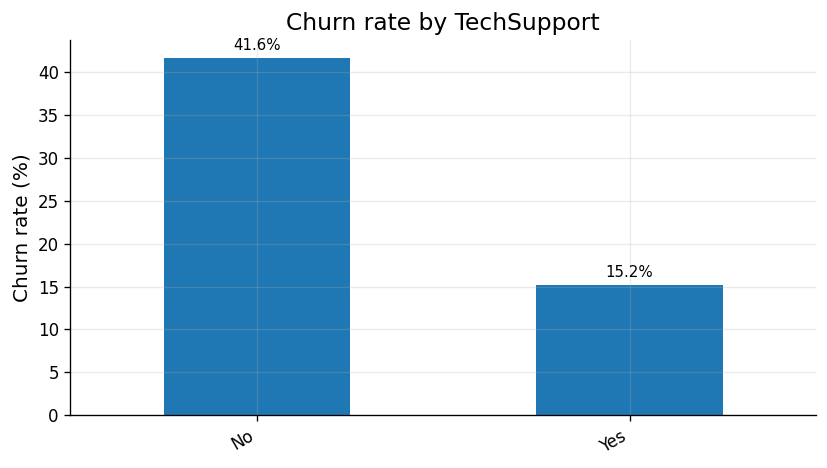

,count,churn_rate_pct
TechSupport,,
No,3473,41.64
Yes,2044,15.17


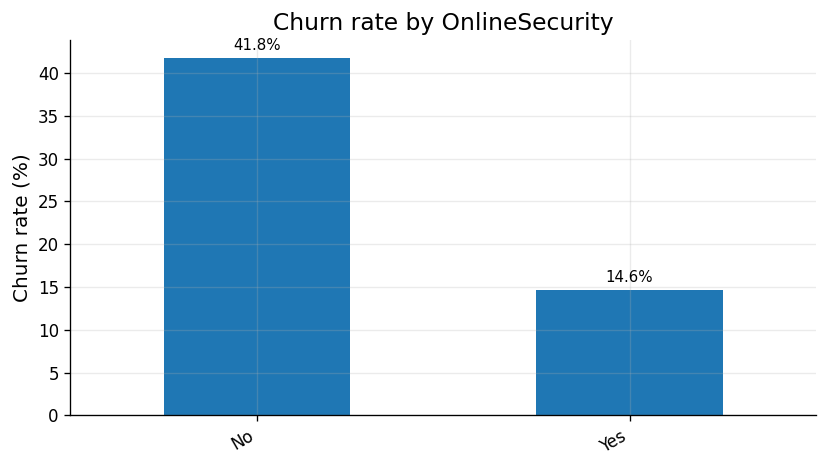

,count,churn_rate_pct
OnlineSecurity,,
No,3498,41.77
Yes,2019,14.61


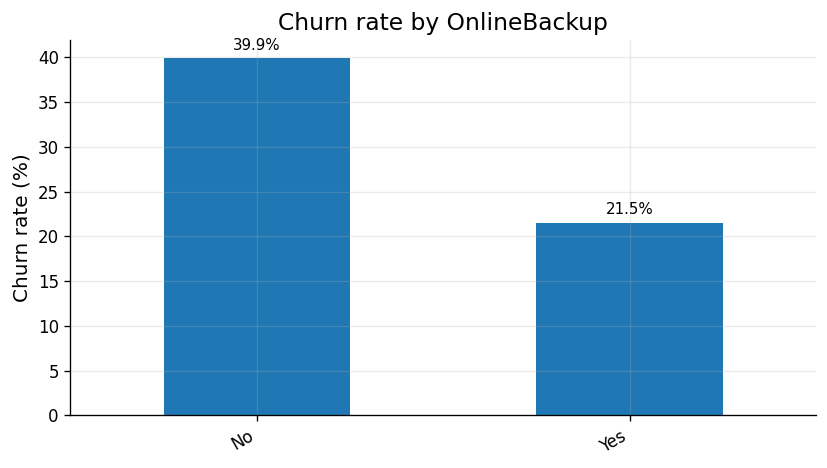

,count,churn_rate_pct
OnlineBackup,,
No,3088,39.93
Yes,2429,21.53


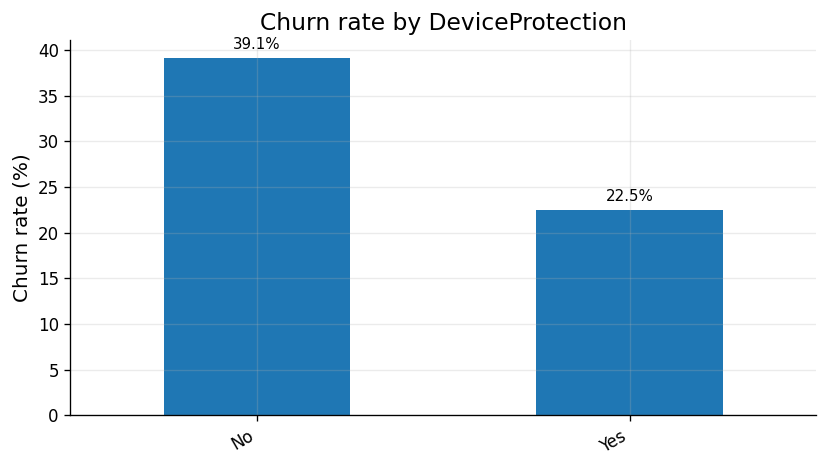

,count,churn_rate_pct
DeviceProtection,,
No,3095,39.13
Yes,2422,22.50


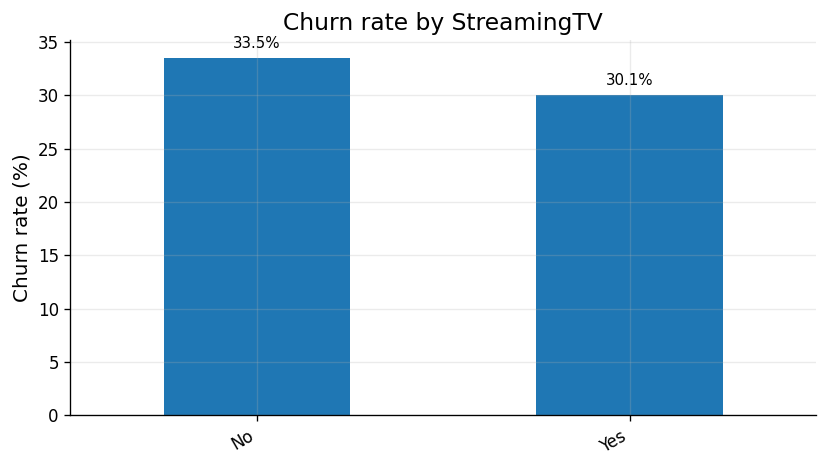

,count,churn_rate_pct
StreamingTV,,
No,2810,33.52
Yes,2707,30.07


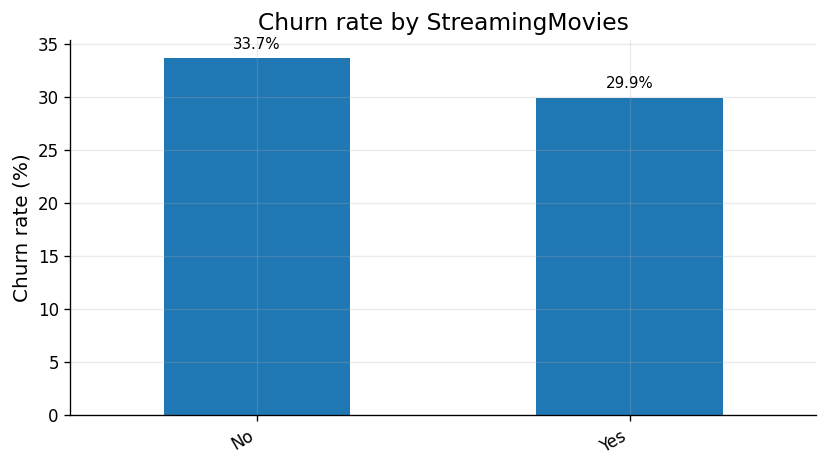

,count,churn_rate_pct
StreamingMovies,,
No,2785,33.68
Yes,2732,29.94


In [11]:
internet_df = df_clean[df_clean["InternetService"] != "No"].copy()

addon_cols = [c for c in ["TechSupport","OnlineSecurity","OnlineBackup","DeviceProtection","StreamingTV","StreamingMovies"] if c in internet_df.columns]

print("Internet customers:", internet_df.shape[0])
print("Addon cols:", addon_cols)

for c in addon_cols:
    display(churn_rate_bar(internet_df, c))


---
## 9) One multivariate view: Contract × InternetService

A simple pivot table makes “risk pockets” obvious without complex modeling.


In [12]:
pivot = df_clean.pivot_table(
    values="Churn",
    index="Contract",
    columns="InternetService",
    aggfunc="mean",
) * 100

pivot = pivot.round(2)
pivot

InternetService,DSL,Fiber optic,No
Contract,,,
Month-to-month,32.22,54.61,18.89
One year,9.30,19.29,2.47
Two year,1.91,7.23,0.78


---
## 10) Build an “at-risk segments” table (portfolio-friendly)

We compute churn rate + segment size for key categorical features, then show the worst groups.


In [13]:
def segment_table(df_in: pd.DataFrame, col: str):
    tab = df_in.groupby(col).agg(
        segment_size=("Churn", "size"),
        churn_rate=("Churn", "mean"),
    )
    tab["churn_rate_pct"] = (tab["churn_rate"] * 100).round(2)
    tab = tab.drop(columns=["churn_rate"]).sort_values(["churn_rate_pct","segment_size"], ascending=[False, False])
    return tab

segments = []
for c in ["Contract","InternetService","PaymentMethod","TechSupport","OnlineSecurity","SeniorCitizen_label"]:
    if c in df_clean.columns:
        tab = segment_table(df_clean, c).reset_index().rename(columns={c:"segment_value"})
        tab.insert(0, "feature", c)
        segments.append(tab)

segments_df = pd.concat(segments, ignore_index=True)

# Keep segments that are non-trivial size (avoid tiny groups)
min_size = max(50, int(0.01 * len(df_clean)))  # at least 1% or 50 customers
segments_df_big = segments_df[segments_df["segment_size"] >= min_size].copy()

segments_df_big.sort_values("churn_rate_pct", ascending=False).head(15)


,feature,segment_value,segment_size,churn_rate_pct
6,PaymentMethod,Electronic check,2365,45.29
0,Contract,Month-to-month,3875,42.71
3,InternetService,Fiber optic,3096,41.89
13,OnlineSecurity,No,3498,41.77
16,SeniorCitizen_label,Yes,1142,41.68
10,TechSupport,No,3473,41.64
17,SeniorCitizen_label,No,5901,23.61
7,PaymentMethod,Mailed check,1612,19.11
4,InternetService,DSL,2421,18.96
8,PaymentMethod,Bank transfer (automatic),1544,16.71


---
## 11) Summary insights (auto-generated)

These bullets are computed from your data and are safe to include in a report.  
(You can rewrite them in your own voice later.)


In [14]:
# 1) tenure effect (median tends to be robust)
med_no = df_clean.loc[df_clean["Churn"]==0, "tenure"].median()
med_yes = df_clean.loc[df_clean["Churn"]==1, "tenure"].median()
tenure_drop_pct = (med_no - med_yes) / med_no * 100 if med_no != 0 else np.nan

# 2) monthly charges effect (mean)
mean_no = df_clean.loc[df_clean["Churn"]==0, "MonthlyCharges"].mean()
mean_yes = df_clean.loc[df_clean["Churn"]==1, "MonthlyCharges"].mean()
mc_increase_pct = (mean_yes - mean_no) / mean_no * 100 if mean_no != 0 else np.nan

overall_churn = df_clean["Churn"].mean() * 100

print(f"- Overall churn rate: {overall_churn:.1f}%")
print(f"- Median tenure is lower for churners by ~{tenure_drop_pct:.1f}% (suggests early-life churn).")
print(f"- Mean MonthlyCharges is higher for churners by ~{mc_increase_pct:.1f}% (price sensitivity signal).")

# top at-risk segments
top_segments = segments_df_big.sort_values("churn_rate_pct", ascending=False).head(5)
print("\nTop at-risk segments (size-filtered):")
display(top_segments)


- Overall churn rate: 26.5%
- Median tenure is lower for churners by ~73.7% (suggests early-life churn).
- Mean MonthlyCharges is higher for churners by ~21.5% (price sensitivity signal).

Top at-risk segments (size-filtered):


,feature,segment_value,segment_size,churn_rate_pct
6,PaymentMethod,Electronic check,2365,45.29
0,Contract,Month-to-month,3875,42.71
3,InternetService,Fiber optic,3096,41.89
13,OnlineSecurity,No,3498,41.77
16,SeniorCitizen_label,Yes,1142,41.68


---
## 12) Next steps (if you want to extend beyond EDA)
- Build a simple baseline model (logistic regression) with one-hot encoding
- Evaluate with ROC-AUC / PR-AUC and interpret with feature importance / coefficients
- Design retention interventions: convert month-to-month to annual, bundle TechSupport, improve billing experience
